# Inventory Risk Analysis Using Purchase Event Data

## Objective

This project analyzes real purchase data from an eCommerce cosmetics store to estimate daily product demand, calculate reorder points, and flag at-risk inventory using only Pandas, NumPy, and Seaborn.
The goal is to simulate a real-world supply chain analyst task — identifying stock shortages before they happen.



File Used: 2019-Dec.csv from https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop?resource=download

## What’s Inside:

- 3.5 million+ rows of product views, cart adds, purchases

- Key columns: event_time, event_type, product_id, price, brand

Here, we load and inspect the dataset to understand the volume and quality of the data.

In [1]:
import pandas as pd

file_path = "/Users/sankalpajoshi/Downloads/Data Science Project Files/2019-Dec.csv"  # replace with your actual path
df = pd.read_csv(file_path)

print(df.head())


                event_time        event_type  product_id          category_id  \
0  2019-12-01 00:00:00 UTC  remove_from_cart     5712790  1487580005268456287   
1  2019-12-01 00:00:00 UTC              view     5764655  1487580005411062629   
2  2019-12-01 00:00:02 UTC              cart        4958  1487580009471148064   
3  2019-12-01 00:00:05 UTC              view     5848413  1487580007675986893   
4  2019-12-01 00:00:07 UTC              view     5824148  1487580005511725929   

  category_code      brand  price    user_id  \
0           NaN      f.o.x   6.27  576802932   
1           NaN        cnd  29.05  412120092   
2           NaN     runail   1.19  494077766   
3           NaN  freedecor   0.79  348405118   
4           NaN        NaN   5.56  576005683   

                           user_session  
0  51d85cb0-897f-48d2-918b-ad63965c12dc  
1  8adff31e-2051-4894-9758-224bfa8aec18  
2  c99a50e8-2fac-4c4d-89ec-41c05f114554  
3  722ffea5-73c0-4924-8e8f-371ff8031af4  
4  28172809-7e

In [2]:
# Step 2: Inspect structure
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Step 3: Overview of columns
print("\nInfo:")
print(df.info())

# Step 4: Summary stats for numeric columns
print("\nDescribe:")
print(df.describe())

# Step 5: Explore event types (view, cart, purchase, etc.)
print("\nEvent Type Breakdown:")
print(df["event_type"].value_counts())

Data shape: (3533286, 9)

First 5 rows:
                event_time        event_type  product_id          category_id  \
0  2019-12-01 00:00:00 UTC  remove_from_cart     5712790  1487580005268456287   
1  2019-12-01 00:00:00 UTC              view     5764655  1487580005411062629   
2  2019-12-01 00:00:02 UTC              cart        4958  1487580009471148064   
3  2019-12-01 00:00:05 UTC              view     5848413  1487580007675986893   
4  2019-12-01 00:00:07 UTC              view     5824148  1487580005511725929   

  category_code      brand  price    user_id  \
0           NaN      f.o.x   6.27  576802932   
1           NaN        cnd  29.05  412120092   
2           NaN     runail   1.19  494077766   
3           NaN  freedecor   0.79  348405118   
4           NaN        NaN   5.56  576005683   

                           user_session  
0  51d85cb0-897f-48d2-918b-ad63965c12dc  
1  8adff31e-2051-4894-9758-224bfa8aec18  
2  c99a50e8-2fac-4c4d-89ec-41c05f114554  
3  722ffea5-73c0

In [3]:
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
event_time             0
event_type             0
product_id             0
category_id            0
category_code    3474821
brand            1510289
price                  0
user_id                0
user_session         779
dtype: int64


## Data Cleaning & Filtering

### Focus: purchase events only

We filtered out views, carts, and removals to focus only on real product purchases — the foundation for calculating demand.

In [11]:
# Step 1: Filter for purchase events only
purchases = df[df["event_type"] == "purchase"].copy()

# Step 2: Confirm shape and preview
print("Total purchases:", purchases.shape[0])
print(purchases.head())

# Step 3: Check for missing values in purchase data
print("\nMissing values in purchase data:")
print(purchases.isnull().sum())

purchases["event_time"] = pd.to_datetime(purchases["event_time"])


Total purchases: 213176
                  event_time event_type  product_id          category_id  \
557  2019-12-01 00:17:50 UTC   purchase        4554  1487580010796548183   
558  2019-12-01 00:17:50 UTC   purchase        4600  1487580010796548183   
559  2019-12-01 00:17:50 UTC   purchase        4607  1487580010796548183   
560  2019-12-01 00:17:50 UTC   purchase        4640  1487580011157258342   
561  2019-12-01 00:17:50 UTC   purchase        4689  1487580010796548183   

    category_code   brand  price    user_id  \
557           NaN  runail   0.38  473613801   
558           NaN  runail   0.38  473613801   
559           NaN  runail   0.38  473613801   
560           NaN  runail   0.37  473613801   
561           NaN  runail   0.38  473613801   

                             user_session  
557  d1e90c6a-c030-4d06-aaaf-6d12ec502bb9  
558  d1e90c6a-c030-4d06-aaaf-6d12ec502bb9  
559  d1e90c6a-c030-4d06-aaaf-6d12ec502bb9  
560  d1e90c6a-c030-4d06-aaaf-6d12ec502bb9  
561  d1e90c6a-c0

## Demand Estimation
### Logic:

For each product, we calculated its average daily demand based on purchase counts per day.

ROP = Avg Daily Demand × Lead Time


In [12]:
# Step 1: Create a 'date' column
purchases["date"] = purchases["event_time"].dt.date

# Step 2: Group by product and date, count purchases
daily_sales = purchases.groupby(["product_id", "date"]).size().reset_index(name="units_sold")

# Step 3: Estimate daily average demand per product
avg_daily_demand = daily_sales.groupby("product_id")["units_sold"].mean().reset_index()
avg_daily_demand.rename(columns={"units_sold": "avg_daily_demand"}, inplace=True)

# Step 4: Preview result
print(avg_daily_demand.head())


   product_id  avg_daily_demand
0        3762          2.518519
1        3763          1.000000
2        3774          1.714286
3        3806          1.000000
4        3928          1.000000


In [13]:
print("Total products sold:", avg_daily_demand.shape[0])
print("Max daily demand:", avg_daily_demand["avg_daily_demand"].max())


Total products sold: 26815
Max daily demand: 53.516129032258064


## Reorder Point Calculation
### We simulated lead time (3–10 days) and current stock (1–50 units) to compute Reorder Points and flag:

🟥 Products below ROP → Reorder Needed

🟩 Products above ROP → Stock OK



In [14]:
import numpy as np

# Step 1: Simulate a lead time (in days) between 3 and 10
np.random.seed(42)  # for reproducibility
avg_daily_demand["lead_time"] = np.random.randint(3, 11, size=avg_daily_demand.shape[0])

# Step 2: Calculate Reorder Point
avg_daily_demand["reorder_point"] = (avg_daily_demand["avg_daily_demand"] * avg_daily_demand["lead_time"]).round(1)

# Step 3: Simulate current stock levels (between 1 and 50)
avg_daily_demand["current_stock"] = np.random.randint(1, 51, size=avg_daily_demand.shape[0])

# Step 4: Flag stock risk
avg_daily_demand["stock_status"] = np.where(
    avg_daily_demand["current_stock"] < avg_daily_demand["reorder_point"],
    "Reorder Needed",
    "Stock OK"
)

# Step 5: Preview
print(avg_daily_demand.head())


   product_id  avg_daily_demand  lead_time  reorder_point  current_stock  \
0        3762          2.518519          9           22.7             38   
1        3763          1.000000          6            6.0             44   
2        3774          1.714286          7           12.0             33   
3        3806          1.000000          9            9.0             21   
4        3928          1.000000          5            5.0             26   

  stock_status  
0     Stock OK  
1     Stock OK  
2     Stock OK  
3     Stock OK  
4     Stock OK  


## Visualizations
### Using Seaborn, we visualized:

- Bar charts: Reorder Point vs. Current Stock

- Heatmaps: Stock Risk by Product

These visual tools help decision-makers quickly identify inventory issues without reading raw data.

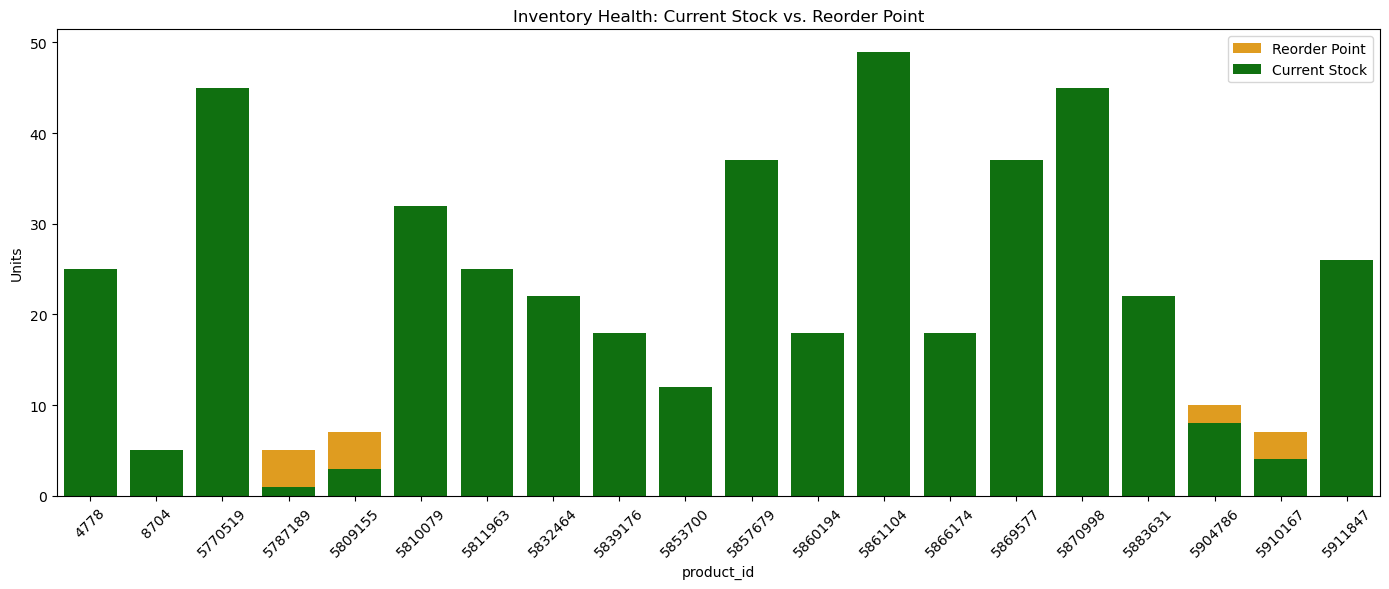

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select a sample of 20 products for plotting
sample = avg_daily_demand.sample(20, random_state=42).sort_values("reorder_point", ascending=False)

# Step 2: Set up barplot (current stock vs. reorder point)
plt.figure(figsize=(14, 6))
sns.barplot(x="product_id", y="reorder_point", data=sample, color="orange", label="Reorder Point")
sns.barplot(x="product_id", y="current_stock", data=sample, color="green", label="Current Stock")

plt.xticks(rotation=45)
plt.ylabel("Units")
plt.title("Inventory Health: Current Stock vs. Reorder Point")
plt.legend()
plt.tight_layout()
plt.show()


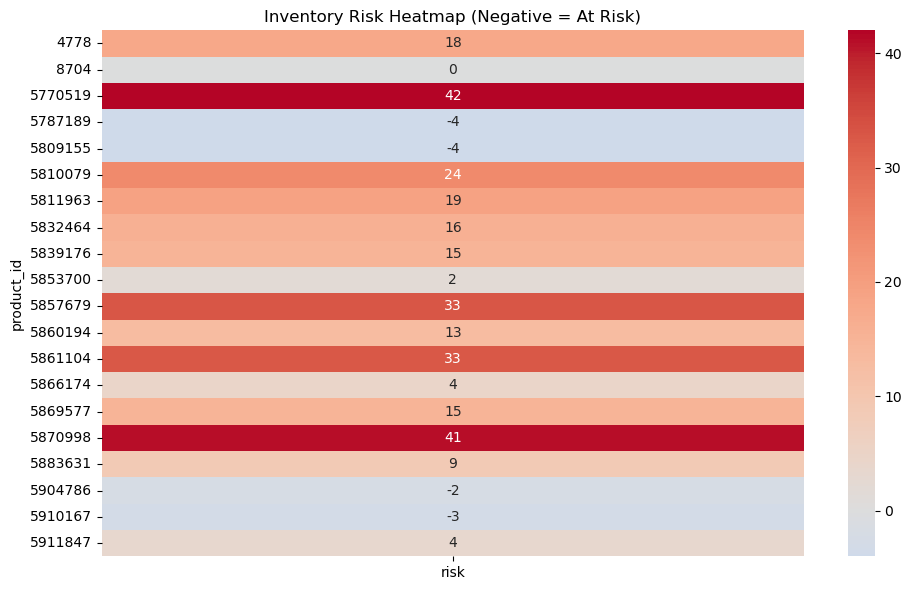

In [10]:
# Step 3: Create a pivot table for heatmap (optional)
pivot = sample.pivot_table(index="product_id", values=["current_stock", "reorder_point"])
pivot["risk"] = pivot["current_stock"] - pivot["reorder_point"]

plt.figure(figsize=(10, 6))
sns.heatmap(pivot[["risk"]], cmap="coolwarm", center=0, annot=True, fmt=".0f")
plt.title("Inventory Risk Heatmap (Negative = At Risk)")
plt.tight_layout()
plt.show()


## Key Takeaways

- Estimated demand directly from transactional data

- Applied core inventory formula (ROP = Demand × Lead Time)

- Flagged high-risk products with simple logic

- Delivered insights in clean visuals

In [15]:
avg_daily_demand.to_csv("final_output.csv", index=False)


In [16]:
plt.savefig("inventory_chart.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>